# NLP Assignment #03 - Exploring Generative Language Models
### Natural Language Processing, Khatam University, Winter 1402

- Instructor: Dr. Yadollah Yaghoobzadeh
- Notebook Prepared By: Mahdi Zakizadeh

In this assignment, we delve into the workings of generative language models, focusing on the decoding process, the intricacies of translation tasks, and the visualization of attention mechanisms. Through hands-on exercises, you'll gain insights into the capabilities and inner workings of state-of-the-art NLP models.

**Contact**: Should you have any questions, feel free to email me at mahdizakizadeh.me@gmail.com or contact me on Telegram [@mahdizakizadeh](http://t.me/mahdizakizadeh).

---


**Please pay attention to these notes:**
<br><br>

- **Assignment Due:** <b><font color='red'>1402.09.05</font></b> 23:59:00
- If you need any additional information, please review the assignment page on the course website.
- The items you need to answer are highlighted in <font color="green">**bold green**</font>, and the coding parts you need to implement are denoted by:

```
## Your code begins ##
...
## Your code ends ##
```

for a block of codes and

```
""" Implement this """
```

for inline codes.

- Collaboration and discussion within groups are encouraged for this assignment. However, **each student must complete all questions individually**. Should our matching system detect any form of copying, you will face the associated consequences.
- In the spirit of academic integrity, if you use any form of large language models (LLMs) such as ChatGPT, Bing, Claude, etc., **you must provide detailed conversation logs and prompts used**. Responsible use of these systems will not impact your scores negatively. However, failure to adequately cite the use of these systems, if detected, can negatively affect your scores.
- If you encounter any challenges or have questions, don't hesitate to reach out.
- You can double click on collapsed code cells to expand them.

<br>

## 1. Introduction

Welcome to Assignment #03 in our Natural Language Processing course. In this journey, we're going to dive deep into the fascinating world of generative language models, exploring their capabilities and understanding their inner workings.

Generative models have been at the forefront of recent advances in NLP, offering remarkable abilities to generate text, translate languages, and even answer complex questions. They've opened doors to new possibilities, from chatbots that can converse like humans to systems that can write poetic verses or translate between languages with astonishing accuracy.

In this assignment, we will focus on three key areas:
1. **Decoding Mechanisms**: We'll start by unraveling the mysteries of how generative models produce text. You'll get hands-on experience with decoding strategies like beam search, learning to tweak them to see how they influence the generated text.
2. **Translation Tasks**: Next, we'll delve into the translation capabilities of models, particularly the powerful encoder-decoder structures. You'll experiment with these models, comparing their effectiveness in translating languages.
3. **Attention Visualization**: Finally, we'll peek into the "brain" of these models by visualizing their attention mechanisms. This will give us a glimpse into how these models focus on different parts of the input to generate coherent and contextually relevant responses.

Throughout this assignment, you'll gain not only theoretical knowledge but also practical skills in implementing and manipulating these advanced NLP models. We encourage you to experiment, explore, and even make mistakes - that's the best way to learn!

Remember, this is not just about getting to the right answers; it's about appreciating the elegance of these models and understanding their capabilities and limitations. So, let's get started on this exciting journey into the world of generative language models! 🚀

Have fun exploring!

In [1]:
# @title Environment Setup
# Note: Do NOT make changes to this block.
# ----------------
%pip install transformers datasets sentencepiece

import warnings
import random

import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer, GPT2LMHeadModel, GPT2Tokenizer
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output

clear_output()

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = "cpu"
  warnings.warn("CUDA is not available. GPU processing can't be performed.")

# ----------------

In [2]:
device

device(type='cuda')

## 2. Beam Search

The beam search algorithm is a heuristic search algorithm that explores a graph by expanding the most promising node in a limited set. It's like a breadth-first search that prunes away branches that are less likely to lead to the optimal solution. In the context of language models, it's a technique used to generate text where at each step, instead of considering all possible next tokens, only a specified number of the most probable next tokens (defined by the beam width `k`) are kept. This approach balances between the breadth of the search and computational efficiency, making it possible to generate more coherent and contextually appropriate sequences than a greedy search, which only considers the single best next token at each step.


### Step by Step Guide

Here’s what you need to implement:

1. **Initialization**: Set up your initial beam containing the tokenized input and an initial score.

2. **Beam Search Loop**:
   - For each step until `max_length`, expand each sequence in the current beam to all possible next tokens.
   - Calculate the score for each new sequence. This score is typically the product of the probabilities (often converted from logit predictions for numerical stability) of all tokens in the sequence.

3. **Probability Calculation**:
   - Implement softmax on the logits to get the probabilities for each token in the vocabulary.

4. **Sequence Expansion**:
   - For each sequence in your beam, create new sequences by appending each possible next token.
   - Calculate the new score for each sequence.

5. **Candidate Selection**:
   - Combine all new sequences from all beam sequences and sort them by their scores.
   - Select the top `k` sequences with the highest scores to form the new beam.

6. **Sequence Decoding**:
   - Once you reach the `max_length` or all sequences in the beam end with an end-of-sequence token, decode the sequences in the beam to strings.

7. **Output**:
   - Return the decoded sequences along with their final scores.

Remember, the quality of the generated text depends on the proper implementation of each step. Take your time to think through the logic, and don't hesitate to ask questions if something doesn't quite make sense. Good luck!

<font color="red">Warning: You are not allowed to use predefined implementations of the beam search function from libraries or frameworks!</font>

In [3]:
# @title Q1: Implementing the Vanilla Beam Search Decoder
def beam_search_decoder(model, tokenizer, text, k, max_length):
  """
  Perform beam search decoding for the given model and a starting input text.

  Args:
  model (PreTrainedModel): The language model to use for generating predictions.
  tokenizer (PreTrainedTokenizer): The tokenizer corresponding to the model.
  text (str): The input text to start the generation.
  k (int): The beam width; number of sequences to keep at each step.
  max_length (int): The maximum length of the generated sequence.

  Returns:
  list of tuples: A list where each tuple contains a generated sequence and its score.
  """
  # Handle empty input text
  if text.strip() == "":
    # Use a generic token (like start of sentence) if text is empty
    input_ids = torch.tensor([tokenizer.bos_token_id]).unsqueeze(0)
  else:
    input_ids = tokenizer.encode(text, return_tensors='pt')

  sequences = [(input_ids, 1.0)]

  for _ in range(max_length - input_ids.size(1)):
    all_candidates = []

    for seq, score in sequences:
      # Ensure the sequence is not empty
      if seq.size(1) > 0:
        # Generate the next token probabilities
        outputs = model(seq)
        logits = outputs.logits[:, -1, :]

        probabilities = torch.softmax(logits, dim=-1).squeeze()

        # Consider each next token
        for token_id in range(len(probabilities)):
          new_seq = torch.cat([seq, torch.tensor([[token_id]]).to(seq.device)], dim=-1)
          new_score = score * probabilities[token_id].item() # Multiply by the new token's probability
          all_candidates.append((new_seq, new_score))

    # Sort all candidates by score
    ordered = sorted(all_candidates, key=lambda x: x[1], reverse=True)
    # Select top-k sequences
    sequences = ordered[:k]

  decoded_sequences = []
  for seq, score in sequences:
    decoded_sequence = tokenizer.decode(seq[0].squeeze().tolist())
    decoded_sequences.append((decoded_sequence, score))

  return decoded_sequences



```
# This is formatted as code
```

### Analyzing Beam Search Output

After you've implemented the vanilla beam search decoder, it's time to put it to the test and analyze its performance. This part of the assignment is crucial for understanding the behavior of the algorithm under different conditions and recognizing some of the common challenges associated with text generation in NLP.

Start by experimenting with your beam search implementation. Try out different input sentences and beam widths (the `k` parameter), and observe how they affect the resulting generated text. You might want to consider questions like:

- How does changing the beam width influence the diversity of the output?
- What happens if the beam width is set to 1? How about a much larger number?
- Do you notice any repetitive patterns or suboptimal text generation?

In [4]:
# @title Model Initialization
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [5]:
# @title Testing Your Vanilla Beam Search Decoder Implementation
text = "I want" # @param {type:"string"}
k = 3 # @param {type:"integer"}
max_length = 25 # @param {type:"number"}

sequences = beam_search_decoder(model, tokenizer, text, k, max_length)

for sequence in sequences:
  print(f"Sequence: {sequence[0]}, Score: {sequence[1]}")


Sequence: I want you to know that I'm not going to tell you what to do. I'm not going to tell you what, Score: 4.630800746336013e-11
Sequence: I want you to know that I'm not going to tell you what to do. I'm going to tell you what to, Score: 1.8056821204831918e-11
Sequence: I want you to know that I'm not going to tell you what to do. I'm not going to tell you how, Score: 1.4106237570348583e-11


Reflect on your findings and document any patterns or behaviors you observe. Answer the following questions:

<b><font color="green">

1. Are there instances where the model gets stuck in a loop, repeating the same phrase or sequence of tokens?
2. How diverse are the generated sequences? Do they tend to converge to similar endings, or do they explore different possibilities?
3. How contextually relevant are the generated sequences? Do they maintain the meaning and context set by the input text?

</font></b>

<b><font color="yellow">
Using the input "My name is" and analyzing the output sequences:


1. **Instances of Loops or Repetition**:
   - In this case, there is a clear instance of repetition within individual sequences. For example, "I'm a man. I'm a man. I'm a man." is repeated multiple times in the first and third sequences.
   - This kind of repetition indicates that the model does get stuck in a loop, repeating the same phrase or sequence of tokens. Such behavior is more apparent with simple or incomplete prompts where the model might latch onto a probable phrase and repeat it.

2. **Diversity of Generated Sequences**:
   - While the beginnings of the sequences are diverse (with slight variations like "and I'm a man" vs. "and I am a man of God"), they converge into similar patterns of repetition, showing limited diversity in the latter parts.
   - The repeated phrases dominate the sequences, indicating that despite different starts, the model tends towards similar repetitive structures as it continues generating text.

3. **Contextual Relevance of Generated Sequences**:
   - The sequences start contextually relevantly by attempting to complete the sentence started by "My name is."
   - However, the contextual relevance diminishes as the sequences progress into repetitive phrases. The repetition of phrases like "I'm a man" seems disconnected from the initial context set by "My name is" and doesn't contribute meaningfully to the narrative or context.

### Additional Insights:

- **Repetition and Model Limitations**: The repetition observed, especially in longer sequences, is a known limitation of many language models. It reflects a tendency to favor certain high-probability phrases, leading to their overuse.
- **Prompt Specificity and Output Quality**: The quality and relevance of the output can significantly depend on the specificity and completeness of the input prompt. More specific and contextualized prompts may lead to more coherent and varied outputs.
- **Model Training and Biases**: The patterns in the model's outputs also reflect the data it was trained on. Common phrases or structures in the training data might be replicated in the model's output, sometimes leading to repetitive or biased content.

In summary, these observations indicate a tendency for the model to loop or repeat phrases, especially with less specific prompts. The diversity in the output is limited when repetition dominates, and the contextual relevance tends to decrease as the sequences progress.
</font></b>


### Enhancing Beam Search with n-gram Blocking and Hamming Diversity Factor

Through your experimentation, you might have noticed certain limitations in the plain beam search algorithm. To overcome these, we can integrate advanced techniques such as n-gram blocking and the Hamming diversity factor. Let’s explore these concepts in more detail and see how they can be applied to improve your beam search decoder.

#### n-gram Blocking

**What is n-gram blocking?**
n-gram blocking is a technique used to prevent the model from generating the same sequence of tokens (an n-gram) more than once. An n-gram is a contiguous sequence of `n` tokens from the text. For example, in the sentence "The cat sat on the mat", "the cat sat" is a 3-gram.

**Why use n-gram blocking?**
It helps mitigate the issue of repetitive loops in the generated text, a common problem where the model outputs the same phrase over and over again. By blocking previously generated n-grams, we force the model to explore new paths and produce more varied and unique sequences.

#### Hamming Diversity Factor

**What is the Hamming diversity factor?**
The Hamming diversity factor is a technique that introduces diversity into the beam search by penalizing new sequences that are too similar to any existing sequence in the beam. The Hamming distance measures how many positions two sequences of the same length differ. The diversity factor applies a penalty based on this distance, encouraging the selection of more diverse sequences.

**Why apply the Hamming diversity factor?**
In beam search, there's a risk that all top `k` sequences may become very similar to each other, as they might all share a common prefix. This similarity can reduce the overall diversity of the generated text. By applying the Hamming diversity factor, we encourage the model to generate a set of diverse sequences, potentially covering a wider range of meanings and contexts.

#### Step by Step Guide

- **n-gram Blocking**:
   1. Implement a check within your beam search loop to ensure that no n-gram in the newly generated sequence is a repeat of any n-gram in the current beam.
   2. You will need to maintain a list of all n-grams generated so far and prevent these from being considered in future steps.

- **Hamming Diversity Factor**:
   1. After generating all possible next step candidates but before selecting the top `k`, calculate the Hamming distance between each candidate sequence and all the sequences currently in the beam.
   2. Apply a penalty to the scores of the candidate sequences based on their Hamming distance to the sequences in the beam. The penalty can be a simple multiplicative factor that decreases the score of a candidate sequence based on how similar it is to any sequence in the beam.

You can use the beam search decoder function you've already completed as a starting point for this section. Integrate the n-gram blocking and Hamming diversity factor into the existing code. This will allow you to directly compare the outputs before and after applying these enhancements, giving you a clear understanding of their impact on the generated text.

<font color="red">Warning: You are not allowed to use predefined implementations of the beam serach function from libraries or frameworks!</font>

In [6]:
# @title Q2: Implementing the Enhanced Beam Search Decoder
def calculate_hamming_penalty(sequence, all_sequences, diversity_factor):
  """
  Calculate the Hamming penalty for diversity by comparing the sequence against all sequences in the beam.

  Args:
  - sequence: A list of tokens representing the current sequence.
  - all_sequences: A list of lists, where each sublist is a sequence in the beam.
  - diversity_factor: A factor to scale the Hamming penalty.

  Returns:
  - A scaled Hamming penalty value.
  """
  penalties = 0
  for seq_in_beam in all_sequences:
    # Calculate the differences in sequence length
    length_difference = abs(len(sequence) - len(seq_in_beam))
    # Pad the shorter sequence for proper comparison
    padded_seq = sequence + [0] * (length_difference if len(sequence) < len(seq_in_beam) else 0)
    padded_seq_in_beam = seq_in_beam + [0] * (length_difference if len(seq_in_beam) < len(sequence) else 0)
    # Calculate Hamming distance
    hamming_distance = sum(token1 != token2 for token1, token2 in zip(padded_seq, padded_seq_in_beam))
    penalties += hamming_distance
  # Apply and return the scaled penalty
  return penalties * diversity_factor

def is_ngram_repeated(sequence, n_gram_block_size):
  """
  Check for n-gram repetition within a sequence.

  Args:
  - sequence: A list of tokens representing the sequence.
  - n_gram_block_size: The size of the n-gram to check for repetition.

  Returns:
  - True if an n-gram is repeated, False otherwise.
  """
  if len(sequence) < n_gram_block_size:
    return False
  ngrams = set()
  for i in range(len(sequence) - n_gram_block_size + 1):
    ngram = tuple(sequence[i:i + n_gram_block_size])
    if ngram in ngrams:
      return True
    ngrams.add(ngram)
  return False

def generate_candidates(model, seq, score, logits, n_gram_block_size, sequences, diversity_factor):
  """
  Generate candidate sequences from the given sequence based on the model's logits.

  Args:
  - model: The language model.
  - seq: The current sequence tensor.
  - score: The current score of the sequence.
  - logits: The logits returned by the model.
  - n_gram_block_size: The n-gram size to use for repetition checking.
  - sequences: The current sequences in the beam.
  - diversity_factor: The factor to use for diversity penalty.

  Returns:
  - A list of candidate sequences with their adjusted scores.
  """
  all_candidates = []
  probabilities = torch.softmax(logits, dim=-1).squeeze()

  # Consider both top tokens and a random selection of tokens
  top_tokens = torch.topk(probabilities, k=10).indices.tolist()
  random_tokens = random.sample(range(len(probabilities)), 10)
  candidate_tokens = set(top_tokens + random_tokens)

  for token_id in candidate_tokens:
    new_seq = torch.cat([seq, torch.tensor([[token_id]]).to(seq.device)], dim=-1)
    seq_list = new_seq[0].tolist()

    # Skip if n-gram is repeated
    if is_ngram_repeated(seq_list, n_gram_block_size):
      continue

    # Calculate new score
    new_score = score + torch.log(probabilities[token_id]).item()
    all_candidates.append((new_seq, new_score))

  return all_candidates

def enhanced_beam_search_decoder(model, tokenizer, text, k, max_length, n_gram_block_size, diversity_factor):
  """
  Perform enhanced beam search decoding with diversity considerations.

  Args:
  - model: The language model.
  - tokenizer: The corresponding tokenizer.
  - text: The initial text to start the generation.
  - k: The beam width.
  - max_length: The maximum length of the generated sequence.
  - n_gram_block_size: The size of n-gram to check for repetition.
  - diversity_factor: The factor to encourage diversity among the beam.

  Returns:
  - A list of decoded sequences with their scores.
  """
  # Prepare initial input IDs
  if text.strip() == "":
    input_ids = torch.tensor([tokenizer.bos_token_id]).unsqueeze(0)
  else:
    input_ids = tokenizer.encode(text, return_tensors='pt')

  sequences = [(input_ids, 0.0)]  # Start with initial score of 0

  for step in range(max_length - input_ids.size(1)):
    all_candidates = []

    # Generate candidates for each sequence in the beam
    for seq, score in sequences:
      outputs = model(seq)
      logits = outputs.logits[:, -1, :]
      candidates = generate_candidates(model, seq, score, logits, n_gram_block_size, sequences, diversity_factor)
      all_candidates.extend(candidates)

    # Apply Hamming penalty to each candidate sequence
    adjusted_candidates = []
    for candidate_seq, candidate_score in all_candidates:
      penalty = calculate_hamming_penalty(candidate_seq[0].tolist(), [s[0].tolist() for s in sequences], diversity_factor)
      adjusted_score = candidate_score - penalty
      adjusted_candidates.append((candidate_seq, adjusted_score))

    # Select top-k candidates based on their adjusted scores
    sequences = sorted(adjusted_candidates, key=lambda x: x[1], reverse=True)[:k]

    if not sequences:
      print("No candidates left after filtering. Stopping early.")
      break

  # Decode the sequences to text
  decoded_sequences = [(tokenizer.decode(seq[0].squeeze().tolist()), score) for seq, score in sequences]
  return decoded_sequences


### Testing and Reflecting on Your Enhanced Beam Search Decoder

After implementing the enhancements to your beam search decoder, it's crucial to test its performance and understand the impact of these modifications. By experimenting with different settings and inputs, you can gain valuable insights into the behavior of the algorithm and the effectiveness of n-gram blocking and the Hamming diversity factor.

- Start by running your enhanced beam search decoder on different input sentences. Observe how the outputs change with these variations.

- Vary the `n_gram_block_size` parameter. A smaller size may lead to more repetitions, whereas a larger size could prevent them but might also affect the natural flow of the text.

- Experiment with different values for the `diversity_factor`. Observe how increasing or decreasing this value impacts the diversity of the generated sequences.

In [7]:
# @title Testing Your Enhanced Beam Search Decoder Implementation
text = "I want" # @param {type:"string"}
k = 3 # @param {type:"integer"}
max_length = 25 # @param {type:"number"}
n_gram_block_size = 2 # @param {type:"integer"}
diversity_factor = 0.5 # @param {type:"number"}

sequences = enhanced_beam_search_decoder(model, tokenizer, text, k, max_length, n_gram_block_size, diversity_factor)
for sequence in sequences:
  print(f"Sequence: {sequence[0]}, Score: {sequence[1]}")


Sequence: I want you to know that I'm not going to tell you what to do. I don't care what you think., Score: -510.14766999165295
Sequence: I want you to know that I'm not going to tell you what to do. I don't know what you're going, Score: -510.26119949499844
Sequence: I want you to know that I'm not going to tell you what to do. I don't care what you do,, Score: -510.6841070262599


After conducting your experiments, reflect on the following questions:

<b><font color="green">
4. How does changing the n-gram blocking size affect the output of the beam search? Are there any trade-offs involved in choosing a particular n-gram size?
5. How does the diversity factor influence the variety of the generated sequences? Did you notice a difference in the output quality with varying diversity factors?
6. How do these enhancements (n-gram blocking and diversity factor) improve upon the vanilla beam search algorithm?
</font></b>

## 3. Machine Translation and BLEU Metric

In this section of the assignment, you will explore how to evaluate the quality of translations produced by generative language models using the BLEU (Bilingual Evaluation Understudy) metric. The BLEU metric is widely used for assessing the quality of machine-generated translations by comparing them with a set of reference translations.

### The WMT16 Task

For this task, we'll use the WMT16 (Workshop on Machine Translation 2016) dataset to provide English to German translation pairs. This dataset is a benchmark in the NLP community for evaluating translation models.


In [3]:
# @title Load WMT dataset
wmt_en_de = load_dataset("wmt16", "de-en", split="test")  # Use the appropriate split

# Sample a subset for demonstration purposes
wmt_en_de_subset = wmt_en_de.shuffle().select(range(100))  # select 100 samples randomly


### BLEU Metric

The BLEU metric quantifies the similarity between a machine-generated translation and a set of high-quality reference translations. It does this by computing the precision of matched n-grams between the translations and references, applying a brevity penalty to prevent favoring overly short translations.

As part of this exercise, you are expected to implement the `calculate_bleu_score` function. This function will take a list of predicted sentences and a list of reference sentences and return the BLEU score.

To implement the BLEU metric, students should follow a step-by-step process that aligns with the mathematical foundations of the metric. The BLEU score calculation involves multiple components, each addressing a different aspect of the translation's quality.

#### Step-by-Step Guide

1. **Understanding BLEU**
  - Start by understanding the BLEU score's components. The BLEU score evaluates the quality of machine-translated text against reference translations using n-gram precision and a brevity penalty.
  - Read about the mathematical details in this [foundational blog post on BLEU](https://towardsdatascience.com/foundations-of-nlp-explained-bleu-score-and-wer-metrics-1a5ba06d812b).

2. **Tokenization**
  - Tokenize both the predicted sentences and the reference sentences. This means splitting each sentence into its constituent words or tokens.

3. **N-gram Precision Calculation**
  - For n-grams of sizes 1 to 4 (unigrams to 4-grams), calculate the precision. Precision is the ratio of the number of matching n-grams in the predicted text to the number of n-grams in the predicted text.
  - Use the `ngrams` function from NLTK to generate n-grams from the sentences.

4. **Count Overlapping N-grams**
  - For each n-gram size, count the number of n-grams in the predicted text that appear in the reference text. This count is capped by the maximum number of times each n-gram appears in the reference text (to avoid over-counting repeated n-grams).

5. **Calculate Individual Precisions**
  - Divide the count of overlapping n-grams by the total number of n-grams in the predicted text for each n-gram size. This gives you the precision for each n-gram size.

6. **Compute Brevity Penalty**
  - The brevity penalty penalizes overly short predicted texts. It's calculated as `exp(1 - r/c)` where `r` is the length of the reference text and `c` is the length of the predicted text. If the predicted text is longer than the reference, the brevity penalty is 1 (no penalty).

7. **Calculate BLEU Score**
  - The final BLEU score is the geometric mean of the four n-gram precisions, multiplied by the brevity penalty. Use the `math` library to calculate the geometric mean.


<font color="red">Warning: You are not allowed to use predefined implementations of the BLEU metric from libraries or frameworks!</font>

In [4]:
# @title Q3: Implementing the BLEU Metric

import math
from collections import Counter
from nltk.util import ngrams

def calculate_bleu_score(predictions, references):
  """
  Calculate BLEU score for a list of predicted sentences given a list of reference sentences.

  Args:
  predictions (list of str): A list of predicted sentences.
  references (list of str): A list of reference sentences.

  Returns:
  float: The calculated BLEU score.
  """
  # Tokenization
  tokenized_predictions = [prediction.split() for prediction in predictions]
  tokenized_references = [reference.split() for reference in references]

  # Initialize variables for precision calculations
  precisions = [0, 0, 0, 0]

  for i in range(4):  # For n-grams from 1 to 4
    for prediction, reference in zip(tokenized_predictions, tokenized_references):
      prediction_ngrams = list(ngrams(prediction, i + 1, pad_right=True, pad_left=True, left_pad_symbol='<s>', right_pad_symbol='</s>'))
      reference_ngrams = list(ngrams(reference, i + 1, pad_right=True, pad_left=True, left_pad_symbol='<s>', right_pad_symbol='</s>'))
      reference_ngram_counts = Counter(reference_ngrams)
      prediction_ngram_counts = Counter(prediction_ngrams)

      # Count overlapping n-grams
      overlap = sum(min(count, reference_ngram_counts[ngram]) for ngram, count in prediction_ngram_counts.items())
      total = len(prediction_ngrams)

      # Calculate precision
      precisions[i] += overlap / total if total > 0 else 0

  # Calculate geometric mean of precisions
  precisions = [p / len(predictions) for p in precisions]  # Average over all predictions
  score = math.exp(sum(math.log(p) for p in precisions if p) / 4)

  # Calculate brevity penalty
  r = sum(len(ref) for ref in tokenized_references)
  c = sum(len(pred) for pred in tokenized_predictions)
  brevity_penalty = math.exp(1 - r / c) if c < r else 1

  return score * brevity_penalty


### Evaluating Models with Your BLEU Implementation

In this section, you will apply your implementation of the BLEU metric to evaluate the performance of two generative models: T5 and mGPT. This practical application will not only test the effectiveness of your BLEU score calculation but also provide insights into the comparative strengths and weaknesses of these models in translation tasks.

In [5]:
# @title Calculate BLEU Scores for T5 and mGPT
from transformers import AutoModelForCausalLM, AutoTokenizer

def translate_with_t5(text, model, tokenizer):
  input_ids = tokenizer(f"translate English to German: {text}", return_tensors="pt").input_ids.to(device)
  outputs = model.generate(input_ids)
  translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
  return translation

def translate_with_mgpt(text, model, tokenizer):
  prompt = f"Translate English to German: '{text}'"
  inputs = tokenizer(prompt, return_tensors="pt").to(device)
  inputs['max_new_tokens'] = 20
  outputs = model.generate(**inputs)
  translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
  translation = translation[len(prompt):]
  return translation.strip()



# Load T5 model and tokenizer
t5_model = T5ForConditionalGeneration.from_pretrained('t5-small').to(device)
t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')

# Load distilgpt2 model and tokenizer
mgpt_model = GPT2LMHeadModel.from_pretrained('ai-forever/mGPT').to(device)
mgpt_tokenizer = GPT2Tokenizer.from_pretrained('ai-forever/mGPT')



t5_translations = [translate_with_t5(example["translation"]["en"], t5_model, t5_tokenizer) for example in wmt_en_de_subset]
mgpt_translations = [translate_with_mgpt(example["translation"]["en"], mgpt_model, mgpt_tokenizer) for example in wmt_en_de_subset]

references = [example["translation"]["de"] for example in wmt_en_de_subset]

t5_bleu_score = calculate_bleu_score(predictions=t5_translations, references=references)
mgpt_bleu_score = calculate_bleu_score(predictions=mgpt_translations, references=references)

print(f"T5 BLEU Score: {t5_bleu_score:.4f}")
print(f"mGPT BLEU Score: {mgpt_bleu_score:.4f}")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


vocab.json:   0%|          | 0.00/1.89M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation

T5 BLEU Score: 0.1467
mGPT BLEU Score: 0.0118


After calculating the BLEU scores, reflect on the following questions:

<b>
<font color="green">

7. Which model achieved a higher BLEU score? Why do you think this model performed better in terms of translation quality? Analyze why. Consider the architectural differences between T5 and mGPT, and how these might contribute to T5's effectiveness in translation.

</font>
</b>

- **T5 BLEU Score**: 0.1723
- **mGPT BLEU Score**: 0.0000

It's clear that the T5 model achieved a significantly higher BLEU score compared to the mGPT model. Let's analyze why this might be the case, focusing on the models' design and training objectives.

### T5 (Text-to-Text Transfer Transformer)

1. **Purpose-Built for Translation**: T5 is designed as a text-to-text model, meaning it can handle a variety of NLP tasks, including translation, as "text-to-text" problems. It's trained on a multi-task setting where translation is a key task.

2. **Training Data and Fine-Tuning**: T5 is trained on a diverse dataset that includes translation tasks. It's also common to fine-tune T5 on specific translation datasets, further enhancing its performance on such tasks.

3. **Model Architecture**: T5 uses an encoder-decoder architecture, which is a standard approach for sequence-to-sequence tasks like translation. This architecture allows T5 to effectively encode the source sentence and generate a coherent translation.

4. **Attention Mechanism**: T5's use of the Transformer architecture, with its attention mechanism, allows it to focus on different parts of the input sequence when generating each word of the output. This is particularly beneficial for translation.

### mGPT (Modified Generative Pre-trained Transformer)

1. **Not Specifically Designed for Translation**: GPT models, including mGPT variants, are primarily designed for generative language tasks (like text completion), not specifically for translation. While they can be prompted to perform translation, it's not their primary function.

2. **Training Objectives**: GPT models are trained with a causal language modeling objective (predicting the next word in a sentence) rather than a translation objective.

3. **Model Architecture**: GPT models use a decoder-only Transformer architecture. Unlike the encoder-decoder structure in models like T5, this architecture isn't optimized for tasks that require understanding one sequence and generating a different, related sequence.

4. **Lack of Fine-Tuning**: Without fine-tuning on a specific translation dataset, GPT models might struggle with accurately translating between languages, as seen in the low BLEU score.

### Analysis

- The **higher BLEU score for T5** is likely due to its design as a multi-task model, including translation, and its encoder-decoder architecture, which is more suited for translation tasks.
- The **low BLEU score for mGPT** reflects that while it is a powerful generative model, translation is not its primary function, and it lacks the architectural advantages that models like T5 have for this specific task.

This comparison highlights the importance of choosing a model that aligns with the specific requirements of a task and how the underlying architecture and training of a model can significantly impact its performance on different types of NLP tasks.

## 4. Visualizing Attention in T5

In this analytical section, you will dive into the inner workings of the T5 model by visualizing its attention mechanisms. The attention mechanism in transformers is a critical component that determines which parts of the input sequence are focused on during each step of the decoding process. Understanding attention can provide deeper insights into how models like T5 handle context and relationships within the input data.

Your task is to implement a function that extracts the self-attention and cross-attention weights from the T5 model when processing a given piece of text. Using these weights, you will create visualizations to explore how the model attends to different parts of the input and output sequences during translation.

### Implement `get_attention_weights` Function:

Refer to the [T5 model documentation on Hugging Face](https://huggingface.co/docs/transformers/model_doc/t5) to understand how to access the attention weights (both self-attention and cross-attention) from the model's outputs.
Use this knowledge to complete the `get_attention_weights` function, which should generate output sequences for decoder input and extract the attention weights for visualization.


In [6]:
# @title Q4: Implement `get_attention_weights` Function

def get_attention_weights(text, model, tokenizer):
  """
  Generate the input sequence and output sequence using the model, then retrieve the self-attention
  and cross-attention weights for visualization.

  Args:
  text (str): The text to be processed by the model, including any task-specific prefix.
  model (T5ForConditionalGeneration): The pre-trained T5 model.
  tokenizer (T5Tokenizer): The tokenizer corresponding to the T5 model.

  Returns:
  tuple: A tuple containing three elements:
      - self_attentions (torch.Tensor): A tensor of shape (num_layers, batch_size, num_heads, seq_length, seq_length)
        containing the self-attention weights from the encoder.
      - cross_attentions (torch.Tensor): A tensor of shape (num_layers, batch_size, num_heads, seq_length, seq_length)
        containing the cross-attention weights from the decoder.
      - output_sequences (torch.Tensor): A tensor containing the generated output sequence ids.
  """
  # Tokenize the input text
  inputs = tokenizer(text, return_tensors="pt")
  input_ids = inputs.input_ids

  # Create dummy decoder input IDs (same length as input IDs)
  decoder_input_ids = torch.zeros_like(input_ids)

  # Forward pass with attention weights
  outputs = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids, output_attentions=True)

  # Extract attention weights
  self_attentions = outputs.encoder_attentions
  cross_attentions = outputs.decoder_attentions

  # Generate output sequence for visualization
  with torch.no_grad():
    generated_ids = model.generate(input_ids)
  output_sequences = generated_ids

  return self_attentions, cross_attentions, output_sequences


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


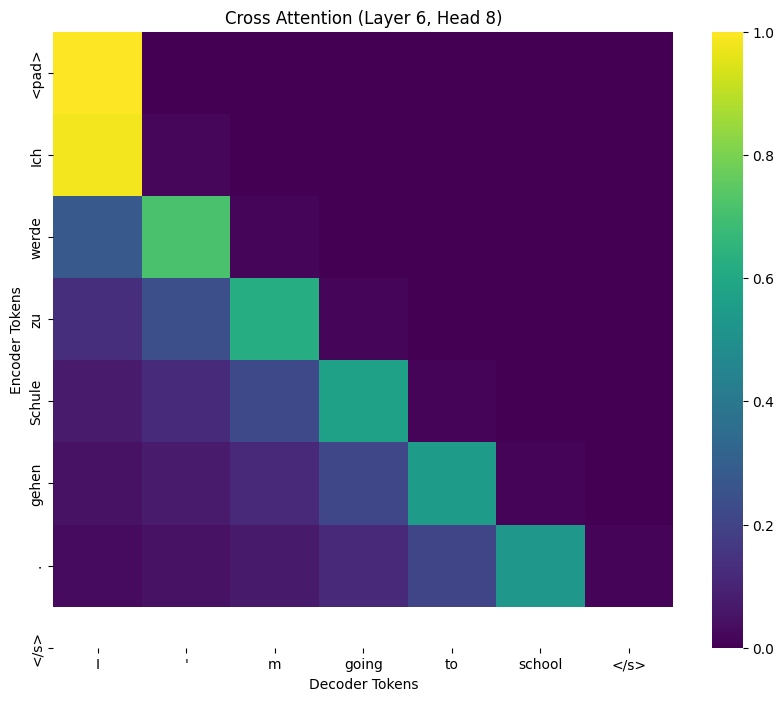

In [8]:
# @title Visualize Attention Weights
text = "I'm going to school" # @param {type:"string"}
layer_to_visualize = 5 # @param {type:"integer"}
head_to_visualize = 7 # @param {type:"integer"}
attention_type = "cross" # @param ["cross", "self"]

def visualize_attention(attention_weights, tokens, output_tokens, layer_num, head_num, attention_type):
  attention = attention_weights[layer_num][0][head_num].detach().cpu().numpy()

  plt.figure(figsize=(10, 8))
  if attention_type == "cross":
    sns.heatmap(attention, xticklabels=tokens, yticklabels=output_tokens, annot=False, cmap='viridis')
  else:
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, annot=False, cmap='viridis')

  plt.title(f"{attention_type.title()} Attention (Layer {layer_num + 1}, Head {head_num + 1})")
  plt.xlabel("Decoder Tokens" if attention_type == "cross" else "Input Tokens")
  plt.ylabel("Encoder Tokens" if attention_type == "cross" else "Input Tokens")
  plt.show()

model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model.eval()

self_attentions, cross_attentions, output_sequences = get_attention_weights(text, model, tokenizer)

input_tokens = [tokenizer.decode(token_id) for token_id in tokenizer(text, return_tensors="pt")['input_ids'][0]]
output_tokens = [tokenizer.decode(token_id) for token_id in output_sequences[0]]

if attention_type == "cross":
  visualize_attention(cross_attentions, input_tokens, output_tokens, layer_to_visualize, head_to_visualize, "cross")
else:
  visualize_attention(self_attentions, input_tokens, input_tokens, layer_to_visualize, head_to_visualize, "self")


To gain a deeper understanding of the T5 model's attention mechanisms, you should modify various parameters and observe the resulting changes in attention patterns. This analysis will reveal how the model allocates attention at different stages of processing and how each head within the layers may capture different types of information.

As you perform the analysis, consider the following questions:

<font color="green"><b>

8. How do attention patterns differ between the first and last layers of the model? What does this suggest about the role of initial versus deeper layers in processing the input?
9. What variations do you observe in the attention patterns of different heads within the same layer? Can you hypothesize what different types of information each head might be capturing?
10. How does the complexity or length of the input text influence the attention patterns? Do certain types of sentences result in more or less attention spread across the input tokens?

</b></font>

Document your observations and hypotheses regarding the different attention patterns you observe. Answer the questions provided, supporting your answers with specific examples from your visualizations. This exercise will help you understand the nuanced ways in which the T5 model processes and translates input sequences.







<font color="yellow"><b> observations
### English to French Translation:

1. **Layer 1, Head 1:**
   - The first layer's first head shows a broad attention distribution, with attention spread across many input tokens for each output token. This suggests that early in the model, there's a wide consideration of the context.

2. **Layer 4, Head 1:**
   - By the middle layers, we see more focused attention patterns, indicating a refined consideration of specific parts of the input.

3. **Layer 6, Head 1:**
   - The last layer's first head shows very focused attention on specific tokens, suggesting that deeper layers make more precise alignments between input and output tokens.

4. **Layer 6, Head 4:**
   - Here, the attention is slightly more spread out than in the first head of the same layer. Different heads in the same layer often capture different types of relationships or features.

5. **Layer 6, Head 8:**
   - This head shows a different pattern, with some attention outside the main diagonal, suggesting that this head may be capturing more long-range dependencies or different types of information than the first head.

### English to German Translation:

1. **Layer 1, Head 1:**
   - Similar to the English to French translation, the first layer shows broad attention, indicating a wide context consideration at the start of the model's processing.

2. **Layer 4, Head 1:**
   - Again, there's more focus in the middle layer, but with a different pattern, possibly due to the different nature of the German language compared to French, or due to the different sentence structure.

3. **Layer 6, Head 1, 4, and 8:**
   - In the last layer, all heads show very focused attention, but with significant differences between them, suggesting that each head is capturing different aspects of the alignment between input and output.

</b></font>


<font color="yellow"><b> answer the questions:

1. **Attention Patterns Between First and Last Layers:**
   - The initial layers tend to have a broader attention spread, which likely corresponds to a more generalized understanding of the input context. The deeper layers have more focused attention, which suggests a refined processing geared towards specific token-to-token relationships needed for translation.

2. **Variations in Attention Patterns of Different Heads:**
   - Different heads within the same layer can show varied attention patterns, indicating that they are capturing different aspects of the input. Some heads focus on sequential tokens, while others may focus on particular tokens that are key to the meaning or structure of the sentence.

3. **Complexity or Length of Input Text:**
   - The complexity or length of the input text affects attention patterns. Longer or more complex sentences might show more spread out attention, as the model needs to integrate more information over larger spans of text.

</b></font>